In [4]:
def calibrate_weights(weights, clip_min=0.001, clip_max=1000):
    """Apply post-processing to weights to improve stability"""
    # Clip extreme values
    weights = np.clip(weights, clip_min, clip_max)
    
    # Normalize to sum to n
    n = len(weights)
    weights = weights * n / np.sum(weights)
    
    return weights
    
def calibrated_PW(A, X, **kwargs):
    """Wrapper around PW that applies calibration to weights"""
    result = PW(A, X, **kwargs)
    result['original_weights'] = result['weights'].copy()  # Keep original weights for comparison
    result['weights'] = calibrate_weights(result['weights'])
    return result

True ATE: 1.0296

Training Standard Logistic...
Original ATE: 1.0666, Calibrated ATE: 1.0666, True ATE: 1.0296
Original weights: min=0.293862, max=3.697410, mean=1.000000
Calibrated weights: min=0.293862, max=3.697410, mean=1.000000

Training SGD Logistic...
Original ATE: 1.7066, Calibrated ATE: 1.7066, True ATE: 1.0296
Original weights: min=0.104028, max=7.402731, mean=1.000000
Calibrated weights: min=0.104028, max=7.402731, mean=1.000000

Training Neural Network...
Original ATE: 1.7323, Calibrated ATE: 1.7323, True ATE: 1.0296
Original weights: min=0.632491, max=1.372015, mean=1.000000
Calibrated weights: min=0.632491, max=1.372015, mean=1.000000

Training PyTorch MLP...


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(















Original ATE: 1.2028, Calibrated ATE: 1.2028, True ATE: 1.0296
Original weights: min=0.626888, max=2.830623, mean=1.000000
Calibrated weights: min=0.626888, max=2.830623, mean=1.000000


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Summary Results:
              method  original_ate_error  calibrated_ate_error  min_weight  \
0  Standard Logistic            0.037030              0.037030    0.293862   
1       SGD Logistic            0.677005              0.677005    0.104028   
2     Neural Network            0.702763              0.702763    0.632491   
3        PyTorch MLP            0.173273              0.173273    0.626888   

   max_weight  
0    3.697410  
1    7.402731  
2    1.372015  
3    2.830623  


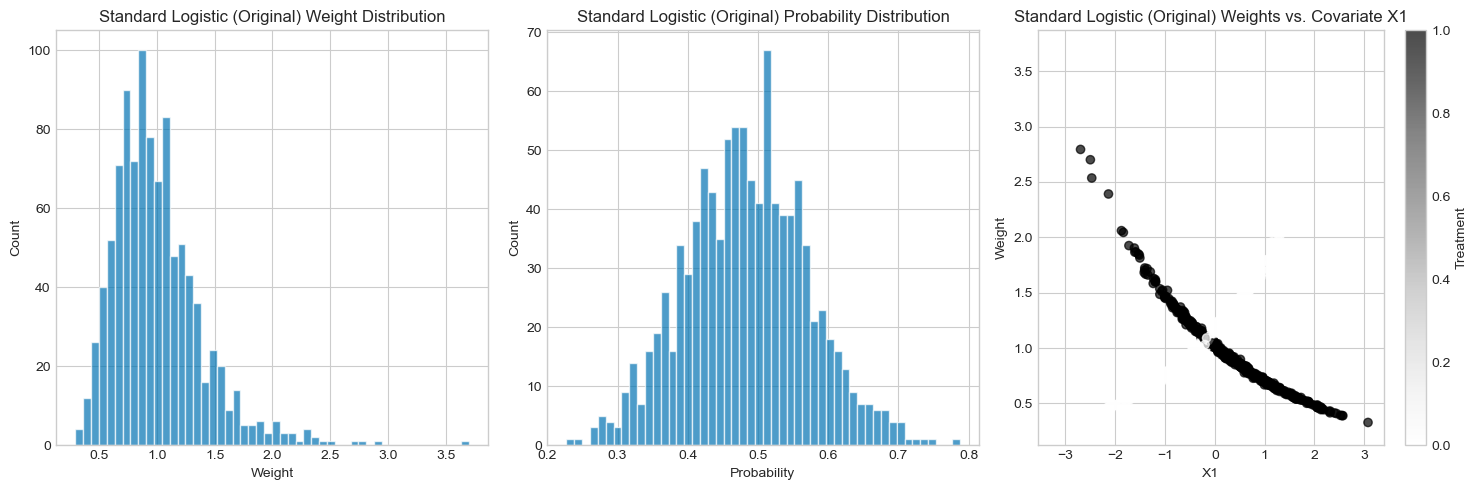

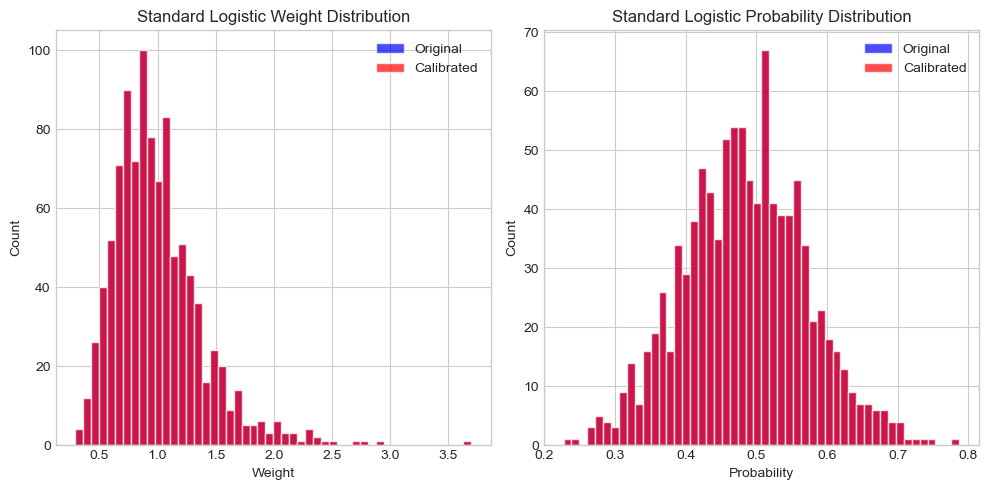

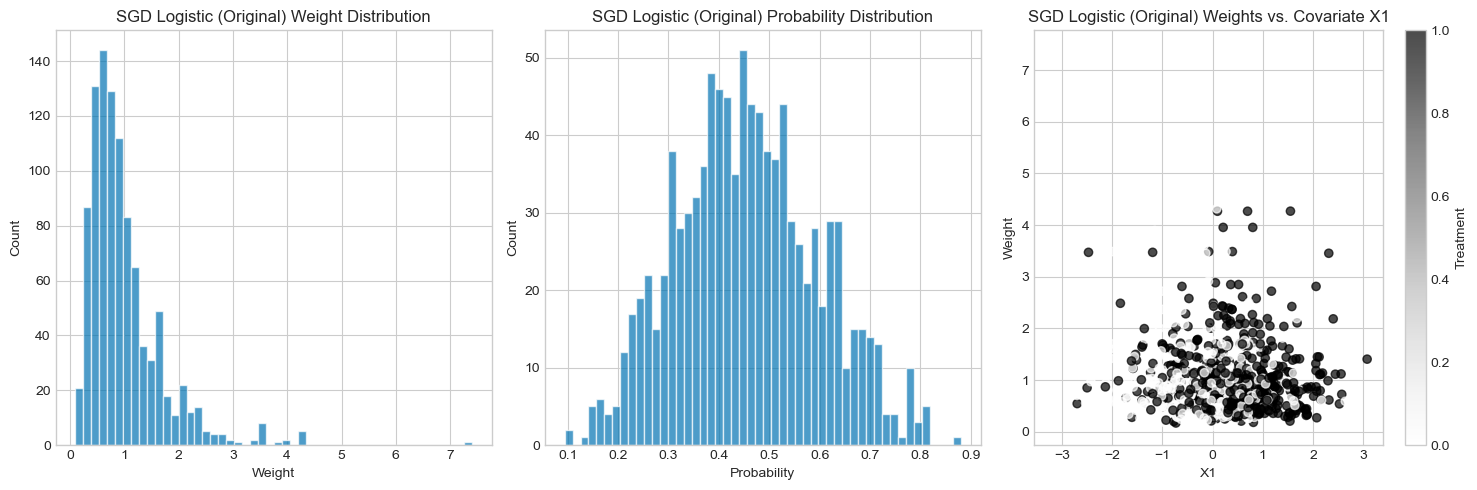

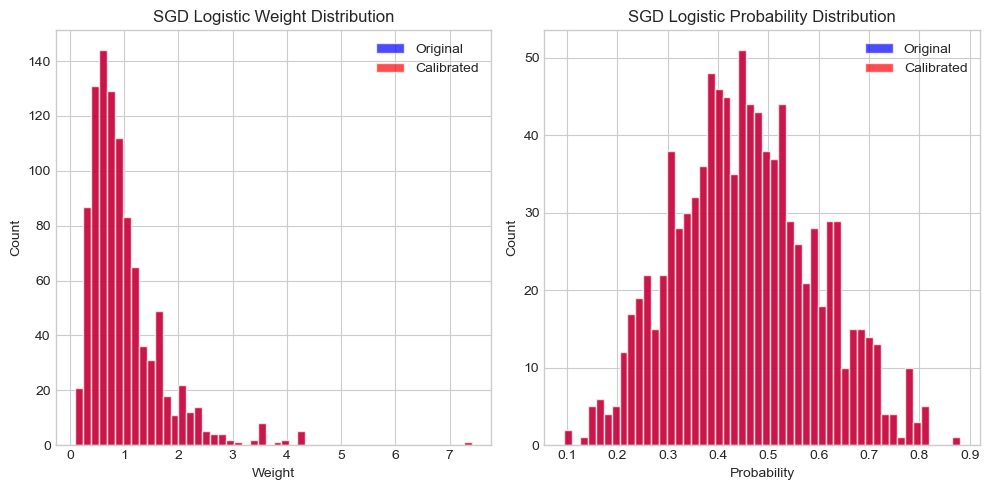

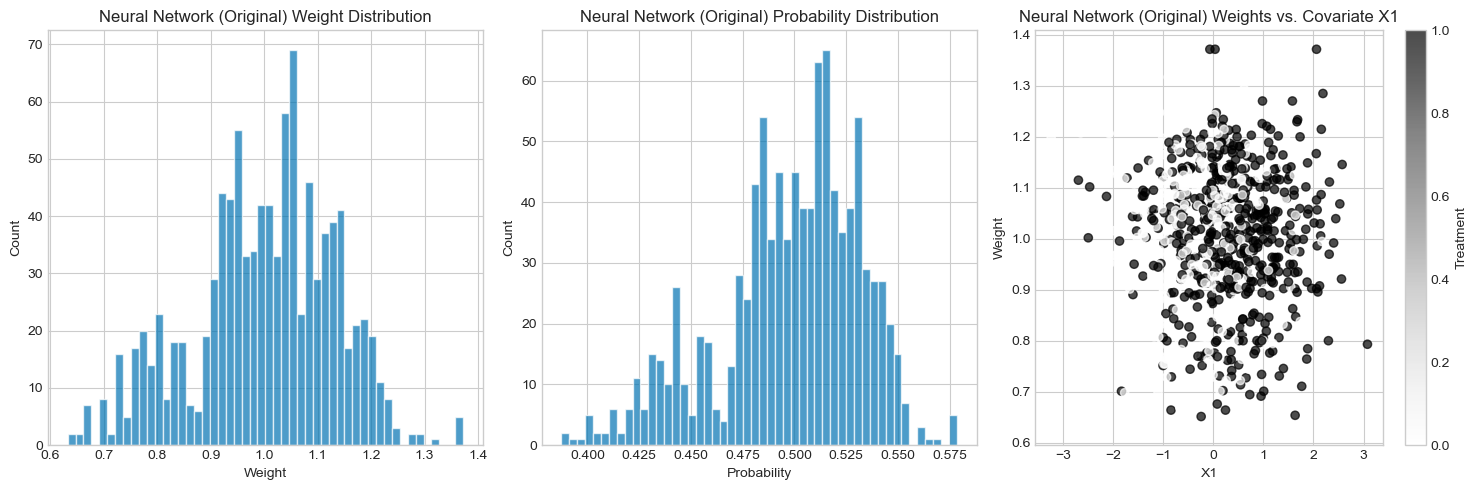

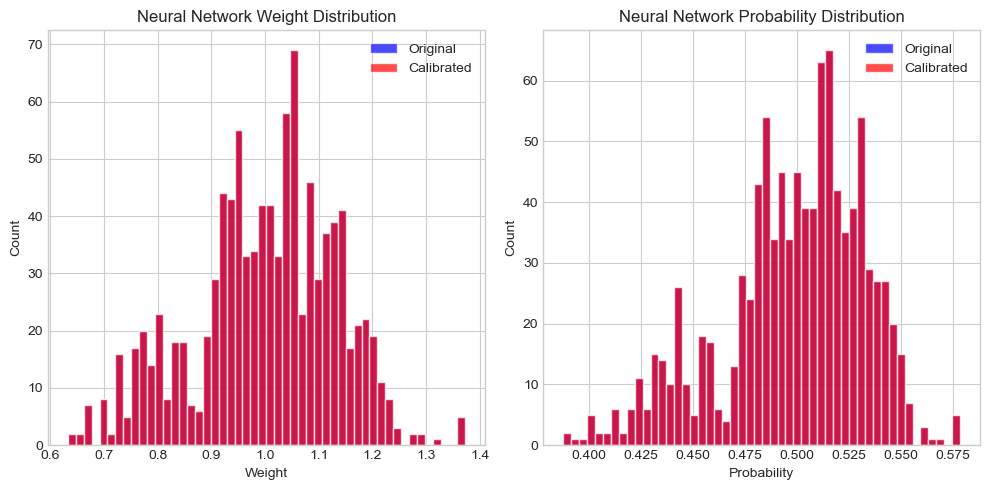

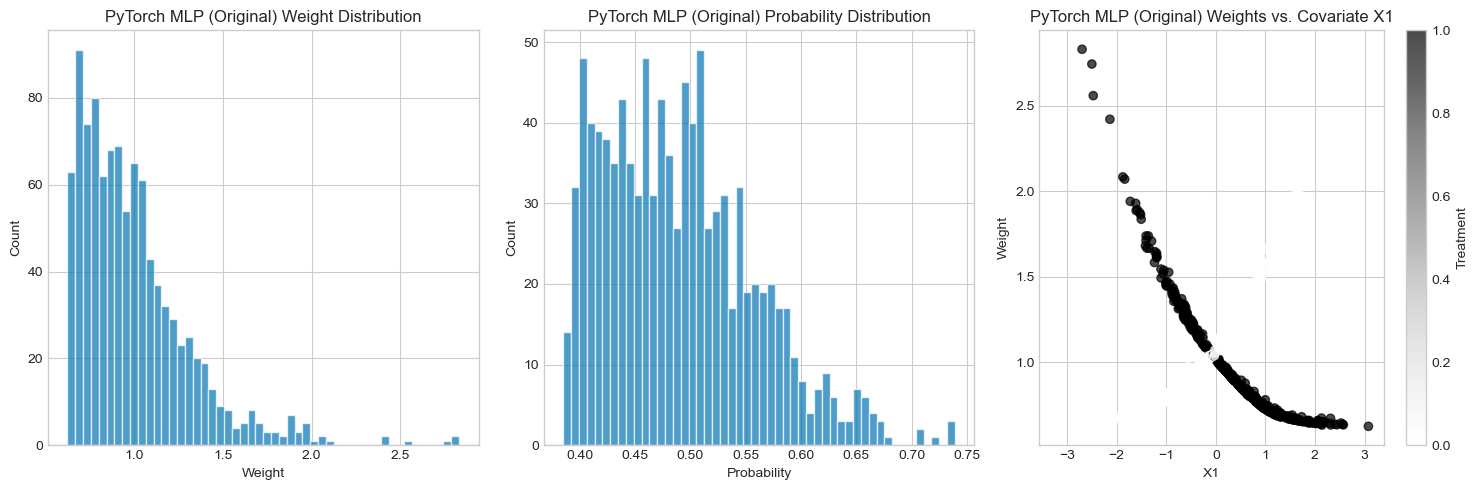

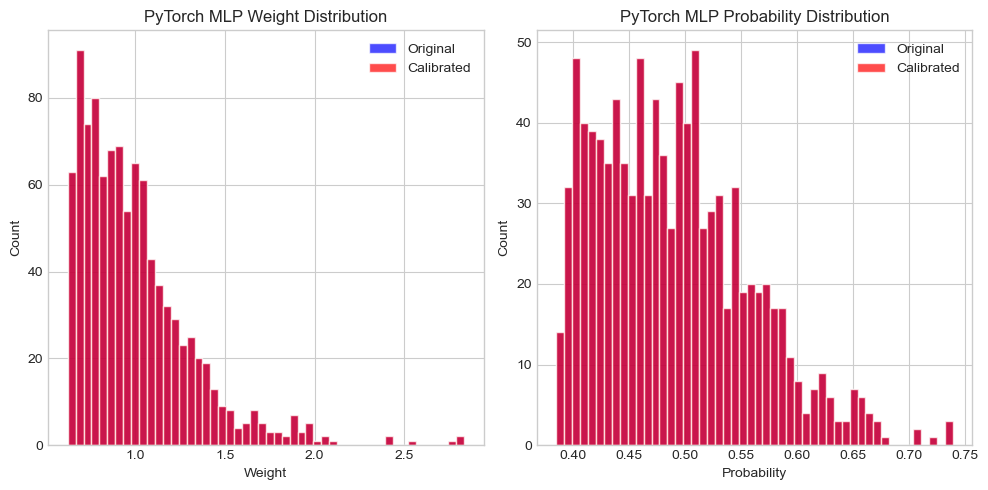

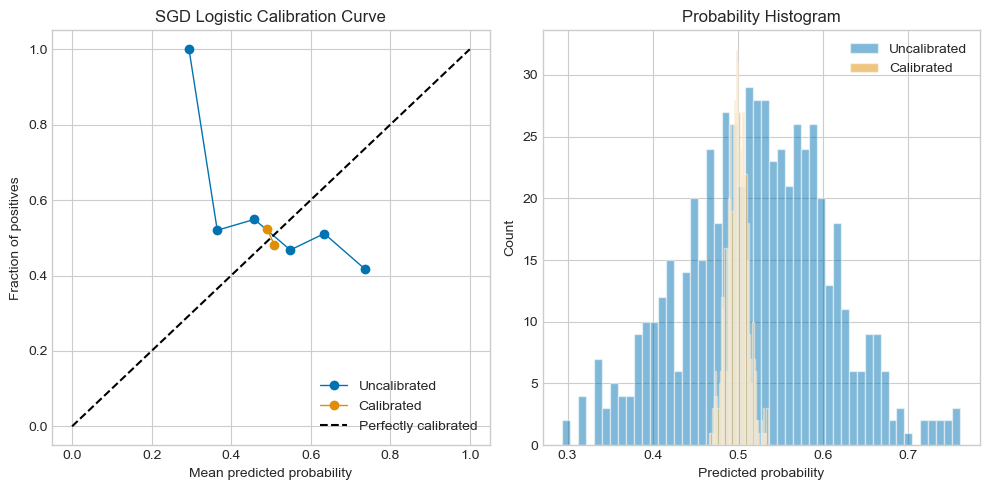

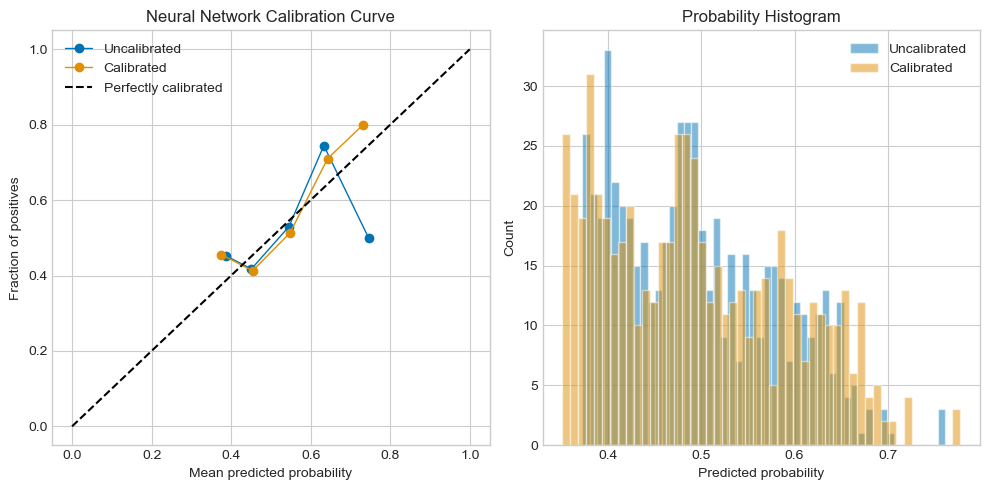

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from permutation_weighting.estimator import PW

# For better plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

def estimate_ate(df, weights):
    """Estimate ATE using PW weights"""
    # Normalize weights to sum to n
    n = len(df)
    normalized_weights = weights * n / np.sum(weights)
    
    # Weighted ATE estimate
    treated_indices = df['A'] == 1
    control_indices = df['A'] == 0
    
    weighted_treated_mean = np.sum(df.loc[treated_indices, 'Y'] * normalized_weights[treated_indices]) / np.sum(normalized_weights[treated_indices])
    weighted_control_mean = np.sum(df.loc[control_indices, 'Y'] * normalized_weights[control_indices]) / np.sum(normalized_weights[control_indices])
    
    return weighted_treated_mean - weighted_control_mean

# Function to generate a simple dataset
def generate_simple_dataset(n=1000, seed=42):
    """Generate a simple dataset with known properties"""
    np.random.seed(seed)
    X = np.random.normal(0, 1, size=(n, 2))
    propensity = 1 / (1 + np.exp(-X[:, 0]))
    A = np.random.binomial(1, propensity, size=n)
    Y1 = 1 + X[:, 0] + np.random.normal(0, 0.5, size=n)
    Y0 = 0 + X[:, 0] + np.random.normal(0, 0.5, size=n)
    Y = A * Y1 + (1 - A) * Y0
    return X, A, Y, Y1, Y0

# Function to visualize weights and probabilities
def analyze_weights(model_name, weights, A, X):
    """Analyze and visualize weights"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(weights, bins=50, alpha=0.7)
    plt.title(f"{model_name} Weight Distribution")
    plt.xlabel("Weight")
    plt.ylabel("Count")
    
    plt.subplot(1, 3, 2)
    probs = weights / (1 + weights)
    plt.hist(probs, bins=50, alpha=0.7)
    plt.title(f"{model_name} Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Count")
    
    plt.subplot(1, 3, 3)
    # Compare weights by treatment group
    plt.scatter(X[:, 0], weights, c=A, alpha=0.7)
    plt.title(f"{model_name} Weights vs. Covariate X1")
    plt.xlabel("X1")
    plt.ylabel("Weight")
    plt.colorbar(label="Treatment")
    
    plt.tight_layout()
    return probs

# Function to compare weight calibration before and after
def compare_calibration(original_weights, calibrated_weights, model_name):
    """Compare weights before and after calibration"""
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(original_weights, bins=50, alpha=0.7, color='blue', label='Original')
    plt.hist(calibrated_weights, bins=50, alpha=0.7, color='red', label='Calibrated')
    plt.title(f"{model_name} Weight Distribution")
    plt.xlabel("Weight")
    plt.ylabel("Count")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    orig_probs = original_weights / (1 + original_weights)
    calib_probs = calibrated_weights / (1 + calibrated_weights)
    plt.hist(orig_probs, bins=50, alpha=0.7, color='blue', label='Original')
    plt.hist(calib_probs, bins=50, alpha=0.7, color='red', label='Calibrated')
    plt.title(f"{model_name} Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.legend()
    
    plt.tight_layout()

# Function to examine a classifier's probability calibration
def examine_classifier_calibration(model, X, A, model_name):
    """Examine probability calibration of a classifier"""
    # Create permuted data
    np.random.seed(42)
    perm_idx = np.random.permutation(len(A))
    A_perm = A[perm_idx]
    
    # Features for classification
    X_combined = np.vstack([X, X])
    A_combined = np.concatenate([A_perm, A])
    
    # Labels: 1 for permuted, 0 for observed
    y_true = np.concatenate([np.ones(len(A)), np.zeros(len(A))])
    
    # Split data
    X_train, X_test, A_train, A_test, y_train, y_test = train_test_split(
        X_combined, A_combined, y_true, test_size=0.3, random_state=42
    )
    
    # Train model
    if model_name == 'SGD Logistic':
        model = SGDClassifier(
            loss='log_loss', 
            penalty='l2', 
            alpha=0.0001, 
            learning_rate='optimal',
            max_iter=1000,
            random_state=42
        )
    elif model_name == 'Neural Network':
        model = MLPClassifier(
            hidden_layer_sizes=(32,),
            activation='relu',
            alpha=0.01,
            learning_rate_init=0.001,
            max_iter=1000,
            random_state=42
        )
    
    # Train model
    model.fit(np.column_stack([A_train.reshape(-1, 1), X_train]), y_train)
    
    # Get predictions
    y_pred = model.predict_proba(np.column_stack([A_test.reshape(-1, 1), X_test]))[:, 1]
    
    # Create calibrated model
    calibrated_model = CalibratedClassifierCV(model, cv='prefit')
    calibrated_model.fit(np.column_stack([A_train.reshape(-1, 1), X_train]), y_train)
    y_pred_calibrated = calibrated_model.predict_proba(np.column_stack([A_test.reshape(-1, 1), X_test]))[:, 1]
    
    # Plot calibration curve
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Uncalibrated')
    
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_calibrated, n_bins=10)
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', linewidth=1, label='Calibrated')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.title(f'{model_name} Calibration Curve')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(y_pred, bins=50, alpha=0.5, label='Uncalibrated')
    plt.hist(y_pred_calibrated, bins=50, alpha=0.5, label='Calibrated')
    plt.title('Probability Histogram')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    
    return model, calibrated_model

# Main execution
if __name__ == "__main__":
    # Generate simple dataset
    X, A, Y, Y1, Y0 = generate_simple_dataset(n=1000)
    true_ate = np.mean(Y1 - Y0)
    print(f"True ATE: {true_ate:.4f}")
    
    # Create a DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'A': A,
        'Y': Y,
        'Y1': Y1,
        'Y0': Y0
    })
    
    # Function to calibrate weights
    def calibrate_weights(weights, clip_min=0.001, clip_max=1000):
        """Apply post-processing to weights to improve stability"""
        # Clip extreme values
        weights = np.clip(weights, clip_min, clip_max)
        
        # Normalize to sum to n
        n = len(weights)
        weights = weights * n / np.sum(weights)
        
        return weights
    
    # Test different models
    models_to_test = [
        ('Standard Logistic', 'logit', {}, False, False),
        ('SGD Logistic', 'logit', {'loss': 'log_loss', 'alpha': 0.0001, 'learning_rate': 'optimal', 'max_iter': 1000}, True, False),
        ('Neural Network', 'neural_net', {'hidden_layer_sizes': (32,), 'alpha': 0.01, 'max_iter': 1000}, True, False),
        ('PyTorch MLP', 'mlp', {'hidden_dims': [32], 'epochs': 25}, False, True)
    ]
    
    results = []
    
    for name, method, params, use_sgd, use_torch in models_to_test:
        print(f"\nTraining {name}...")
        
        try:
            # Train standard PW model
            pw_result = PW(
                A=A, X=X, 
                classifier=method, 
                classifier_params=params,
                estimand='ATE',
                num_replicates=1,
                use_sgd=use_sgd,
                use_torch=use_torch
            )
            
            # Get weights and calculate ATE
            original_weights = pw_result['weights']
            
            # Apply calibration
            calibrated_weights = calibrate_weights(original_weights)
            
            # Calculate ATE with both sets of weights
            original_ate = estimate_ate(df, original_weights)
            calibrated_ate = estimate_ate(df, calibrated_weights)
            
            # Analyze weights
            print(f"Original ATE: {original_ate:.4f}, Calibrated ATE: {calibrated_ate:.4f}, True ATE: {true_ate:.4f}")
            print(f"Original weights: min={np.min(original_weights):.6f}, max={np.max(original_weights):.6f}, mean={np.mean(original_weights):.6f}")
            print(f"Calibrated weights: min={np.min(calibrated_weights):.6f}, max={np.max(calibrated_weights):.6f}, mean={np.mean(calibrated_weights):.6f}")
            
            # Visualize weights
            original_probs = analyze_weights(f"{name} (Original)", original_weights, A, X)
            plt.savefig(f"{name.replace(' ', '_')}_original_weights.png", dpi=300)
            
            # Compare calibration
            compare_calibration(original_weights, calibrated_weights, name)
            plt.savefig(f"{name.replace(' ', '_')}_calibration_comparison.png", dpi=300)
            
            # Save results
            results.append({
                'method': name,
                'original_ate': original_ate,
                'calibrated_ate': calibrated_ate,
                'true_ate': true_ate,
                'original_ate_error': abs(original_ate - true_ate),
                'calibrated_ate_error': abs(calibrated_ate - true_ate),
                'min_weight': np.min(original_weights),
                'max_weight': np.max(original_weights),
                'mean_weight': np.mean(original_weights)
            })
            
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
    
    # Examine classifier calibration for problematic methods
    sgd_model, sgd_calibrated = examine_classifier_calibration(None, X, A, 'SGD Logistic')
    plt.savefig("SGD_Logistic_calibration.png", dpi=300)
    
    nn_model, nn_calibrated = examine_classifier_calibration(None, X, A, 'Neural Network')
    plt.savefig("Neural_Network_calibration.png", dpi=300)
    
    # Print summary results
    print("\nSummary Results:")
    results_df = pd.DataFrame(results)
    print(results_df[['method', 'original_ate_error', 'calibrated_ate_error', 'min_weight', 'max_weight']])